# Data exploration

In [19]:
import datasets

dataset = datasets.load_dataset('eve-esa/eve-cpt-sample-v0.2')['train']

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def sample_dataset(dataset: datasets.Dataset, num_bins: int, n_samples: int = 1000):
    """
    Sample the dataset accordingly to the distribution of the lengths of the examples.
    :param dataset: 
    :param num_bins: 
    :param n_samples: 
    :return: 
    """
    lengths = np.array([get_length(example) for example in dataset])
    hist, bin_edges = np.histogram(lengths, bins=num_bins, density=True)

    # Assign each example to a bin
    bin_indices = np.digitize(lengths, bins=bin_edges, right=True)
    
    # Sample from each bin proportionally
    sampled_indices = []
    for i in range(1, num_bins + 1):
        bin_members = np.where(bin_indices == i)[0]
        if len(bin_members) > 0:
            num_samples = int(n_samples * len(bin_members) / len(lengths))
            sampled_indices.extend(np.random.choice(bin_members, size=num_samples, replace=False).tolist())
    
    
    if len(sampled_indices) > n_samples:
        # Ensure exactly 1000 samples
        sampled_indices = np.random.choice(sampled_indices, size=n_samples, replace=False)
        
    return dataset.select(sampled_indices)


# Load dataset (replace with your dataset)

# Define a function to compute length of each example
def get_length(text: str):
    return len(text.split())  # Change to len(example["text"]) for character length

def plot_lengths(texts: list[str], num_bins=50):
    # Compute lengths
    lengths = np.array([get_length(text) for text in texts])
    
    # Print bins ranges and counts
    hist, bin_edges = np.histogram(lengths, bins=num_bins, density=False)
    for i in range(len(bin_edges) - 1):
        print(f"Bin {i}: [{bin_edges[i]:.0f}, {bin_edges[i + 1]:.0f}]")
        print(f"Count: {hist[i]:.2f}")
        
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=num_bins, alpha=0.75, color='blue', edgecolor='black')
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.title("Dataset Length Distribution")
    plt.grid(True)
    plt.show()

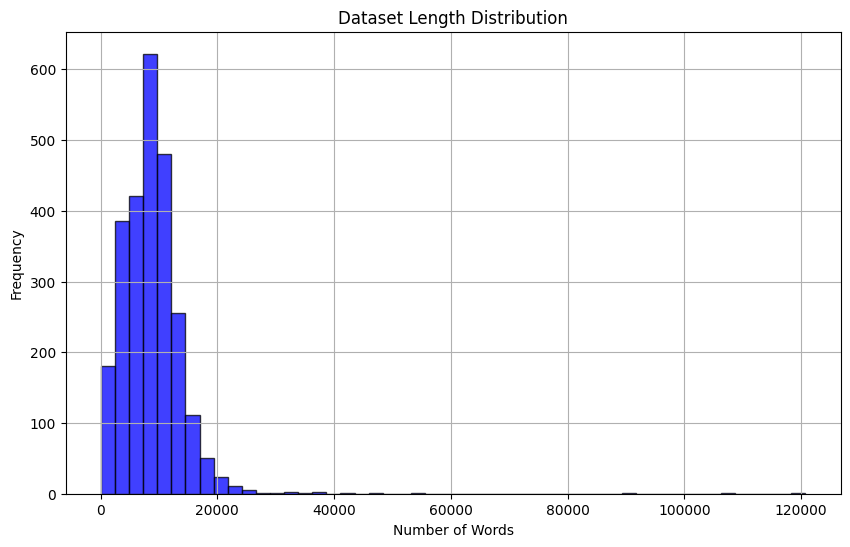

In [3]:
plot_lengths(dataset)

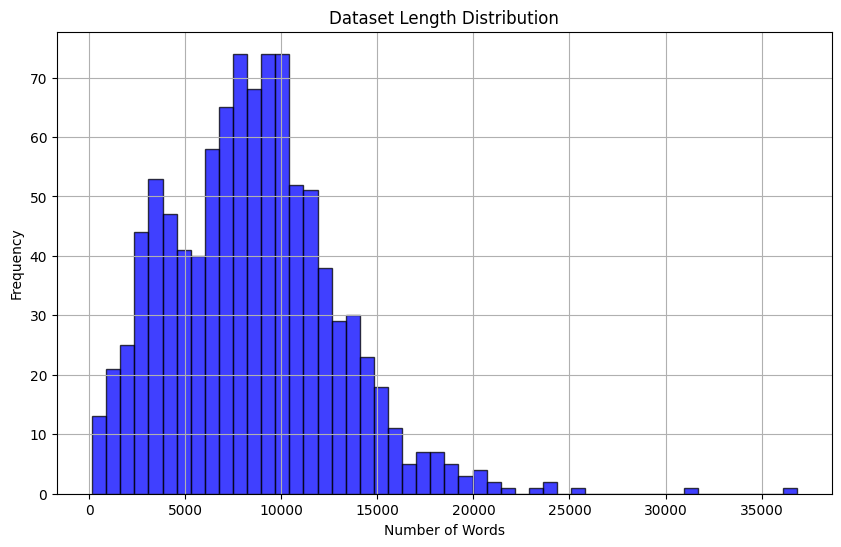

In [4]:
sampled_dataset = sample_dataset(dataset, num_bins=50, n_samples=1000)
plot_lengths(sampled_dataset)

In [2]:
# Extract and remove abstarct from the dataset
import re

def extract_abstract(sample):
    # Regex to extract the abstract
    abstract_pattern = re.compile(r"#{0,6}(\s|.)Abstract\s*\n\n(.*?)(_Keywords.*?|#{0,6}\s*.*Introduction)", re.S | re.I)
    #abstract_pattern = re.compile(r"(#|\*){0,6}\s*Abstract.*\n\n(.*?)(#{0,6}\s*.*Introduction)", re.S | re.I)
    text = sample['text']
    # Extract abstract
    match = abstract_pattern.search(text)
    if match:
        abstract = match.group(1).strip()
    else:
        # Interrupt the abstract to the new paragraph
        abstract_pattern = re.compile(r"(#|\*){0,6}\s*Abstract.*\n\n(.*?)\n\n", re.S)
        match = abstract_pattern.search(text)
        if match:
            abstract = match.group(1).strip()
        else:
            abstract = None

    # Remove abstract from text
    text_without_abstract = abstract_pattern.sub("", text).strip()
    return {'text': text_without_abstract, 'abstract': abstract}





def remove_references(text):
    """
    Removes the references section.
    Detects a heading containing 'references' and captures its content
    until the end of the text.
    """
    # Regex pattern to match a heading containing "references"
    references_pattern = re.compile(r"(\n\s*#{1,6}\s*references\s*\n)(.*$)", re.I | re.S)

    # Search for the references section
    match = references_pattern.search(text)
    if match:
        text = text[:match.start()].strip()  # Keep everything up to the start of the references section
    
    return text


def remove_acknowledgements(text):
    """
    Removes the acknowledgements section.
    Detects a heading containing 'acknowledgements' and captures its content
    until the next section heading.
    """
    # Regex pattern to match a heading containing "acknowledgements"
    acknowledgements_pattern = re.compile(r"(\n\s*#{1,6}\s*acknowledgements\s*\n)(.*?)(?=\n\s*#{1,6}\s*\w+)", re.I | re.S)

    # Search for the acknowledgements section
    match = acknowledgements_pattern.search(text)
    if match:
        text = text[:match.start()].strip()  # Keep everything up to the start of the acknowledgements section
    
    return text


def extract_headings(text):
    """
    Extracts the headings from the text.
    """
    # Regex pattern to match headings
    heading_pattern = re.compile(r"#{1,6}\s*.*", re.I)

    # Find all headings
    headings = heading_pattern.findall(text)
    
    return headings


In [55]:
import re

def find_abstract(sample):
    # Try with the first pattern
    #result = find_section(sample, 'abstract')
    regex = re.compile(r"#{1,6}\s*.*", re.I)
    
    text = sample['text']
    abstract = None
    headings = list(regex.finditer(text))
    
    section_idx = None
    next_section_idx = None
    for i, heading in enumerate(headings):
        if 'abstract' in heading.group().lower():
            section_idx = i
            next_section_idx = i + 1
            break
            
    print(headings[section_idx].group(), headings[next_section_idx].group())
    # If the abstract is not found, try with the second pattern
    if section_idx is None or (next_section_idx < len(headings) and 'introduction' not in headings[next_section_idx].group().lower()):
        # Try finding tha Abstract as newline title
        pattern = re.compile(r"(\bAbstract\b)\n\n*(.*)", re.I)
        match = pattern.search(sample['text'])
        if match:
            abstract = match.group(2)
            text = pattern.sub("", sample['text']).strip()
    else:
        start_section_title = headings[section_idx].start()
        start_section = headings[section_idx].end()
        end_section = headings[next_section_idx].start() if next_section_idx < len(headings) else len(text)
        
        abstract = text[start_section:end_section].strip()
        text = text[:start_section_title] + text[end_section:]
    return {'text': text, 'abstract': abstract}
        

def remove_after_section(sample, section_name='conclusion'):
    """
    Removes everything after the conclusions section.
    Detects a heading containing 'conclusion' and captures its content
    until the next section heading.
    """
    # Regex pattern to match a heading containing "conclusion"
    conclusion_pattern = re.compile(r"(\n\s*#{1,6}\s*.*"+ section_name +".*\n)(.*?)(?=\n\s*#{1,6}\s*\w+)", re.I | re.S)
    
    text = sample['text']

    # Search for the conclusion section
    match = conclusion_pattern.search(text)
    if match:
        after_conclusion = text[match.end():]
        text = text[:match.end()].strip()  # Keep everything up to the end of the conclusion section
    else:
        after_conclusion = None
    
    return {'text': text, 'after_'+section_name: after_conclusion}

def bold_to_heading_with_section(sample, section='Abstract'):
    """
    Converts bold markdown (`**section**`) into heading 1 markdown (`# section`).
    """
    text = sample['text']
    pattern = r'\*\*.*{}.*\*\*'.format(section)
    # Replace the bold text with heading 1 using the provided section
    return {'text': re.sub(pattern, f'# {section}\n', text, re.I)}

def find_section(sample, section_name='abstract'):
    regex = re.compile(r"#{1,6}\s*.*", re.I)
    
    text = sample['text']
    
    headings = list(regex.finditer(text))
    
    section_idx = None
    next_section_idx = None
    for i, heading in enumerate(headings):
        if section_name in heading.group().lower():
            section_idx = i
            next_section_idx = i + 1
            break
    if section_idx is None:
        section = None
    else:
        start_section_title = headings[section_idx].start()
        start_section = headings[section_idx].end()
        end_section = headings[next_section_idx].start() if next_section_idx < len(headings) else len(text)
        
        section = text[start_section:end_section].strip()
        text = text[:start_section_title] + text[end_section:]
    return {section_name: section, 'text': text}

# Process pipeline

In [40]:
from tqdm.notebook import tqdm
import pandas as pd
import datasets

dataset = datasets.load_dataset('eve-esa/eve-cpt-sample-v0.2')['train']

# Remove documents without abstract
dataset_processed = dataset.filter(lambda x: 'abstract' in x['text'].lower())
# Print the number of samples without abstract
print(f"Number of samples without abstract: {len(dataset) - len(dataset_processed)}")
# Convert MD **abstract** to # Abstract
dataset_processed = dataset_processed.map(bold_to_heading_with_section)
# Convert MD **Introduction** to # Introduction
dataset_processed = dataset_processed.map(bold_to_heading_with_section, fn_kwargs={'section': 'Introduction'})

# Make a copy of the text column for debugging
dataset_processed = dataset_processed.map(lambda x: {'text': x['text'], 'original_text': x['text']})

# Extract abstract
dataset_processed = dataset_processed.map(find_abstract)

## Section cleaning

# Convert MD **conclusion** to # Conclusion
dataset_processed = dataset_processed.map(bold_to_heading_with_section, fn_kwargs={'section': 'conclusion'})
# Remove after conclusions
dataset_processed = dataset_processed.map(remove_after_section, fn_kwargs={'section_name': 'conclusion'})
# Remove after references
dataset_processed = dataset_processed.map(find_section, fn_kwargs={'section_name': 'references'})

data_pd = dataset_processed.to_pandas()

Number of samples without abstract: 588


Map:   0%|          | 0/1972 [00:00<?, ? examples/s]

Map:   0%|          | 0/1972 [00:00<?, ? examples/s]

Map:   0%|          | 0/1972 [00:00<?, ? examples/s]

Map:   0%|          | 0/1972 [00:00<?, ? examples/s]

## Preprocessing analysis

In [41]:
# Show samples without abstract
data_pd[data_pd['abstract'].isna()]

,article_title,text,original_text,abstract,after_conclusion,references
96,1204.5531v2,# Morphisms of generalized interval systems an...,# Morphisms of generalized interval systems an...,None,\n## References\n\n* [1] Marcel Berger. _Geome...,None
209,0412502v1,**SOLAR ABUNDANCE OF ELEMENTS FROM NEUTRON-CAP...,**SOLAR ABUNDANCE OF ELEMENTS FROM NEUTRON-CAP...,None,None,None
234,0603747v1,# Splitting the automorphism group of an abeli...,# Splitting the automorphism group of an abeli...,None,None,"* [1] Beletskii, P and Morgado, E. _On the aut..."
246,0601050v1,"Comments on: ""Increasing destructiveness of tr...","Comments on: ""Increasing destructiveness of tr...",None,\n## References\n\n* Atkinson and Holliday (19...,None
251,1103.6012v1,**STATE EQUATION FOR DENSE GASES AND LIQUIDS**...,**STATE EQUATION FOR DENSE GASES AND LIQUIDS**...,None,None,"* [1] J.O. Hirschfelder, C.F. Curtis and R.B. ..."
...,...,...,...,...,...,...
1837,mdpi_volume_10_issue_10_article_162,Spectral Invariant Provides a Practical Modeli...,Spectral Invariant Provides a Practical Modeli...,None,"\n## References\n\n* (1) Zhao, J.; Li, J.; Liu...",None
1870,mdpi_volume_10_issue_1_article_10,# Trend Detection for the Extent of Irrigated ...,# Trend Detection for the Extent of Irrigated ...,None,"\n## References\n\n* (1) Carleton, T.A.; Hsian...",None
1882,mdpi_volume_10_issue_12_article_100,# Developing Land-Use Regression Models to Est...,# Developing Land-Use Regression Models to Est...,None,\n## References\n\n* _Bartelli et al. (2013)_ ...,"* (1) Dockery, D.W.; Pope, C.; Xu, X.; Spengle..."
1899,mdpi_volume_10_issue_12_article_83,Spatiotemporal Evolution of Postseismic Deform...,Spatiotemporal Evolution of Postseismic Deform...,None,\n## References\n\n* Burgmann and Dresen (2008...,None


In [10]:
# Show samples without conclusion
data_pd[data_pd['after_conclusion'].isna()]

,article_title,text,abstract,after_conclusion,references
2,1207.4754v1,# Scaling mechanism for efficient wavelength c...,Laser-induced ionization is a fundamental tool...,None,"* [1] J. Tate, T. Auguste, H. Muller, P. Salie..."
3,1204.3030v1,# One possible mechanism for massive neutron s...,The recently discovery of a massive neutron st...,None,* (1) P. A. M. Dirac _Natural_**139** (1937) 3...
4,1103.4224v1,# Gas Slit Camera (GSC) onboard MAXI on ISS\n\...,The Gas Slit Camera (GSC) is an X-ray instrume...,None,"* [1]\n* [2]Conner, J. P., Evans, W. D., & Bel..."
13,1112.5284v1,"# From FAIR to RHIC, hyper clusters and an eff...",Two major aspects of strange particle physics ...,None,"* [1] M. Gyulassy and L. McLerran, Nucl. Phys...."
15,1109.3319v1,"# Lines, dots and spirals on Peruvian land\n\n...","The most famous geoglyphs of Peru are the ""Naz...",None,None
...,...,...,...,...,...
1787,mdpi_volume_10_issue_10_article_95,# AMSR2 Soil Moisture Downscaling Using Temper...,Soil moisture (SM) applications in terrestrial...,None,"* Njoku and Enetkhabi 1996 Njoku, E.G.; Entekh..."
1814,mdpi_volume_10_issue_10_article_131,# Decadal Changes of Earth's Outgoing Longwave...,The Earth Radiation Budget (ERB) at the top of...,None,* (1) IPCC. _The Physical Science Basis_; Camb...
1816,mdpi_volume_10_issue_10_article_132,A Novel Integrated Approach of Relevance Vecto...,This research aims at proposing a new artifici...,None,"* Varnes (1978) Varnes, D.J. Slope movement ty..."
1862,mdpi_volume_10_issue_12_article_41,"Correction: Mottus, M. et al. Measurement of D...","In Figures 3 and 4 of [1], we noticed incorrec...",None,"* Mottus et al. (2018) Mottus, M.; Hernandez-C..."


In [16]:
data_pd['text']

0       # SAR Image Segmentation using Vector Quantiza...
1       # Migration of Gas Giant Planets in Gravitatio...
2       # Scaling mechanism for efficient wavelength c...
3       # One possible mechanism for massive neutron s...
4       # Gas Slit Camera (GSC) onboard MAXI on ISS\n\...
                              ...                        
1967    Upscaling Solar-Induced Chlorophyll Fluorescen...
1968    Mapping Root-Zone Soil Moisture Using a Temper...
1969    Landslide Susceptibility Mapping and Compariso...
1970    Evaluation of Sensor and Environmental Factors...
1971    # Generation of High Resolution Vegetation Pro...
Name: text, Length: 1972, dtype: object

In [11]:
with open('sample.txt', 'w') as f:
    f.write(data_pd['text'][1509])

In [42]:
# Filter nan abstracts
data_pd = data_pd[~data_pd['abstract'].isna()]
plot_lengths(data_pd['abstract'], num_bins=100)

NameError: name 'plot_lengths' is not defined

In [45]:
# Select all samples with less then 1000 words
data_short = data_pd[data_pd['abstract'].apply(lambda x: len(x.split()) > 1500)]
data_short

,article_title,text,original_text,abstract,after_conclusion,references
24,1210.6154v2,**UNIVERSIDAD NACIONAL DE INGENIERIA**\n\n**FA...,**UNIVERSIDAD NACIONAL DE INGENIERIA**\n\n**FA...,A GIS based software is presented which permit...,\n### Diagrams de despliegueFigure 198. Diagra...,
189,1010.1171v1,"M. L. Mistchandor, V. K. Rosenbush, N. N. Mele...","M. L. Mistchandor, V. K. Rosenbush, N. N. Mele...",The \(T\) matrix of the \(T\) matrix is obtain...,"\n## Spectral filters\n\nU, B, V, R, I\n\nBroa...",
328,1011.0391v1,**The Titicaca basin: a paradigmatic region fo...,**The Titicaca basin: a paradigmatic region fo...,We propose a survey of the literature about ar...,None,None
374,1007.1548v1,# _Stability Analysis of GI/G/c/K Retrial Queu...,# _Stability Analysis of GI/G/c/K Retrial Queu...,We present a new method for estimating the sta...,\n## References\n\n[MISSING_PAGE_EMPTY:24],"* [1] J.R. Artalejo, ""Stationary analysis of t..."
490,1009.2231v2,**Symbolic landforms created by ancient earthw...,**Symbolic landforms created by ancient earthw...,Interesting landforms created by an ancient ne...,None,None
562,0810.2843v1,# The calculation of the equation of state of ...,# The calculation of the equation of state of ...,"In this paper, we give a direct method for cal...",None,None
668,1010.0436v1,# Modeling the scaling properties of human mob...,# Modeling the scaling properties of human mob...,While the fat tailed jump size and the waiting...,None,None
868,1008.5011v1,**Small simple impact craters**\n\n**Amelia Ca...,**Small simple impact craters**\n\n**Amelia Ca...,The paper discusses some examples of image pro...,None,None
878,0207004v1,Education Curricula of the Regional Centres fo...,Education Curricula of the Regional Centres fo...,"Since 1988, the United Nations, through the Pr...",None,None
1103,Atmospheric_Chemistry_and_Physics_volume_10_is...,"Atmos. Chem. Phys., 10, 279-298, 2010 www.atmo...","Atmos. Chem. Phys., 10, 279-298, 2010 www.atmo...",Atmospheric composition and chemistry above tr...,"\n## References\n\n* (1)\n* (2)Andreae, M. and...",None


In [52]:
with open('sample.txt', 'w') as f:
    f.write(data_short['original_text'][328])

In [56]:
find_abstract({'text': data_short['original_text'][328]})

IndexError: list index out of range

In [18]:
for x in data_pd.iterrows():
    print(x)
    break

(0, text        # SAR Image Segmentation using Vector Quantiza...
abstract    The development and application of various rem...
Name: 0, dtype: object)


## Save dataset

In [12]:
# Keep only the text and abstract columns
data_pd = data_pd[['article_title', 'text', 'abstract']]
# Save the processed dataset
data_pd.to_csv('dataset.csv', index=False)

In [57]:
from datasets import load_dataset

data = load_dataset('eve-esa/eve-cpt-sample-v0.2')

In [58]:
data

DatasetDict({
    train: Dataset({
        features: ['article_title', 'text'],
        num_rows: 2560
    })
})